# Import

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import geocoder
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/Library/Fonts/Arial Unicode.ttf"
fontprop = fm.FontProperties(fname=font_path, size=18)

In [2]:
geocoder.distance?

## 파일 불러오기

In [6]:
with open("/Users/heogeonhyeock/Desktop/인빅_프로젝트/FC주문/FC_order.pickle","rb") as fr:
    Distance = pickle.load(fr).reset_index(drop=True)
Distance

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,...,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2,distance_송화,distance_수화,distance
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,131425,50.0,N,경기도,광주시,경상남도,김해시,14.3362,270.613,284.949
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,131425,53.0,N,경기도,광주시,경상남도,거제시,14.3362,294.613,308.949
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,131425,6.0,N,경기도,광주시,서울특별시,서초구,14.3362,32.841,47.1772
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,78.6173
5,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,2,2475138283,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,78.6173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786343,KX007,2021063075245201,KX007210702671565,7,20210630,122001,90001622,125800.0,1,5519470982_18,...,101425,7.0,N,경기도,광주시,서울특별시,동작구,14.3362,41.4585,55.7948
1786347,KX007,2021062954478421,KX007210702674788,7,20210629,122812,90001443,16900.0,1,5002901762_12,...,122203,16.0,N,경기도,광주시,경기도,수원시,14.3362,28.4156,42.7518
1786348,KX007,2021063067849541,KX007210703706457,7,20210630,256,90001662,138000.0,1,5410093340,...,220152,63.0,N,경기도,광주시,제주특별자치도,제주시,14.3362,432.125,446.461
1786349,KX007,2021063078029521_1,KX007210704717899,7,20210630,143118,90001443,13900.0,1,5582399098,...,55047,34.0,N,경기도,광주시,대전광역시,유성구,14.3362,106.525,120.861


# 데이터 전처리

## Null값 제거 & CORP_ID = 곤지암 hub

In [ ]:
Distance = Distance[Distance["CORP_ID"] == "KX007"].dropna(axis=0)

## 5개 미만의 데이터 즉 노이즈 제거

In [ ]:
Df_list = ["SHPR_ADDR_1","SHPR_ADDR_2","CNEE_ADDR_1","CNEE_ADDR_2"]
Df_list2 = ["SHPR_ADDR_2","CNEE_ADDR_2"]
Distance = Distance[Df_list]

Df_index = []
for i in Df_list2:
    for j in list(Distance[i].unique()):
        if len(Distance[Distance[i] == j]) < 5:
            Df_index.append(Distance[Distance[i] == j].index)
            
for i in Df_index:
    Distance = Distance.drop(index = i)
Distance

## New Collum 송화인과 수화인 생성

In [ ]:
Distance["송화인"] = Distance["SHPR_ADDR_1"] + " " + Distance["SHPR_ADDR_2"]
Distance["수화인"] = Distance["CNEE_ADDR_1"] + " " + Distance["CNEE_ADDR_2"]
Distance = Distance.drop(Df_list, axis = 1).reset_index(drop=False)
Distance

# geocoder를 이용한 거리계산

## 거리계산 결과 Dict 생성
    A = set(Distance["송화인"].unique())
    B = set(Distance["수화인"].unique())
    A < B => True
    (즉 송화인의 고유값 집합이 수화인의 고유값 집합에 포함됨)

In [ ]:
A = list(Distance["수화인"].unique())
Distance_Dict = {}
KX007_loc = geocoder.location("경기도 광주시 도척면 진우리 1006") # 곤지암 Hub 위치

for i in A:
    try:
        Distance_Dict[i] = geocoder.distance(geocoder.location(i),KX007_loc)
    except:
        Distance_Dict[i] = None

for i,j in Distance_Dict.items():
    if j == 0:
        Distance_Dict[i] = None

## 거리계산 결과 저장

In [ ]:
with open("Distance_Dict2.pickle","wb") as fw:
    pickle.dump(Distance_Dict, fw)

## 거리계산 결과 불러오기

In [5]:
with open("/Users/heogeonhyeock/Desktop/인빅_프로젝트/Distance_Dict2.pickle","rb") as fr:
    Distance_Dict = pickle.load(fr)

# 데이터프레임 생성

## 파일 불러오기

In [3]:
with open("/Users/heogeonhyeock/Desktop/인빅_프로젝트/FC주문/FC_order.pickle","rb") as fr:
    Distance = pickle.load(fr).reset_index(drop=True)

## 데이터 전처리
    2 데이터 전처리와 동일한 방식

In [7]:
# Null값 제거 & CORP_ID = 곤지암 hub
Distance = Distance[Distance["CORP_ID"] == "KX007"].dropna(axis=0)

# 5개 미만의 데이터 즉 노이즈 제거
Df_list2 = ["SHPR_ADDR_2","CNEE_ADDR_2"]
Df_index = []
for i in Df_list2:
    for j in list(Distance[i].unique()):
        if len(Distance[Distance[i] == j]) < 5:
            Df_index.append(Distance[Distance[i] == j].index)
            
for i in Df_index:
    Distance = Distance.drop(index = i)
Distance

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,...,DLVSUBCLSFCD,INS_ID,INS_DATE,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,4,iNEXBatch,20210303,131425,50.0,N,경기도,광주시,경상남도,김해시
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,0,iNEXBatch,20210303,131425,53.0,N,경기도,광주시,경상남도,거제시
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,1,iNEXBatch,20210303,131425,6.0,N,경기도,광주시,서울특별시,서초구
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,1,iNEXBatch,20210303,131425,10.0,N,경기도,광주시,경기도,김포시
5,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,2,2475138283,...,1,iNEXBatch,20210303,131425,10.0,N,경기도,광주시,경기도,김포시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786343,KX007,2021063075245201,KX007210702671565,7,20210630,122001,90001622,125800.0,1,5519470982_18,...,8,iNEXBatch,20210702,101425,7.0,N,경기도,광주시,서울특별시,동작구
1786347,KX007,2021062954478421,KX007210702674788,7,20210629,122812,90001443,16900.0,1,5002901762_12,...,1,iNEXBatch,20210702,122203,16.0,N,경기도,광주시,경기도,수원시
1786348,KX007,2021063067849541,KX007210703706457,7,20210630,256,90001662,138000.0,1,5410093340,...,3,iNEXBatch,20210703,220152,63.0,N,경기도,광주시,제주특별자치도,제주시
1786349,KX007,2021063078029521_1,KX007210704717899,7,20210630,143118,90001443,13900.0,1,5582399098,...,1m,BATCH,20210704,55047,34.0,N,경기도,광주시,대전광역시,유성구


## 거리 정보열 생성

In [8]:
Distance["distance_송화"] = None
Distance["distance_수화"] = None
Distance["distance"] = None
Distance

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,...,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2,distance_송화,distance_수화,distance
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,131425,50.0,N,경기도,광주시,경상남도,김해시,None,None,None
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,131425,53.0,N,경기도,광주시,경상남도,거제시,None,None,None
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,131425,6.0,N,경기도,광주시,서울특별시,서초구,None,None,None
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,131425,10.0,N,경기도,광주시,경기도,김포시,None,None,None
5,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,2,2475138283,...,131425,10.0,N,경기도,광주시,경기도,김포시,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786343,KX007,2021063075245201,KX007210702671565,7,20210630,122001,90001622,125800.0,1,5519470982_18,...,101425,7.0,N,경기도,광주시,서울특별시,동작구,None,None,None
1786347,KX007,2021062954478421,KX007210702674788,7,20210629,122812,90001443,16900.0,1,5002901762_12,...,122203,16.0,N,경기도,광주시,경기도,수원시,None,None,None
1786348,KX007,2021063067849541,KX007210703706457,7,20210630,256,90001662,138000.0,1,5410093340,...,220152,63.0,N,경기도,광주시,제주특별자치도,제주시,None,None,None
1786349,KX007,2021063078029521_1,KX007210704717899,7,20210630,143118,90001443,13900.0,1,5582399098,...,55047,34.0,N,경기도,광주시,대전광역시,유성구,None,None,None


## 계산결과 적용

In [15]:
for i in list(Distance.index):
    try:
        Distance["distance_송화"][i] = Distance_Dict[(Distance["SHPR_ADDR_1"][i] + " " + Distance["SHPR_ADDR_2"][i])]
    except:
        print("{}번째 인덱스에서 오류".format(i))       
    try:
        Distance["distance_수화"][i] = Distance_Dict[Distance["CNEE_ADDR_1"][i] + " " + Distance["CNEE_ADDR_2"][i]]
    except:
        print("{}번째 인덱스에서 오류".format(i))

Distance["distance"] = Distance["distance_송화"] + Distance["distance_수화"]
Distance

<ipython-input-15-ea3a4c8b4488>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Distance["distance_송화"][i] = Distance_Dict[(Distance["SHPR_ADDR_1"][i] + " " + Distance["SHPR_ADDR_2"][i])]
<ipython-input-15-ea3a4c8b4488>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Distance["distance_수화"][i] = Distance_Dict[Distance["CNEE_ADDR_1"][i] + " " + Distance["CNEE_ADDR_2"][i]]


,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,...,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2,distance_송화,distance_수화,distance
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,131425,50.0,N,경기도,광주시,경상남도,김해시,14.3362,270.613,None
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,131425,53.0,N,경기도,광주시,경상남도,거제시,14.3362,294.613,None
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,131425,6.0,N,경기도,광주시,서울특별시,서초구,14.3362,32.841,None
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,None
5,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,2,2475138283,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786343,KX007,2021063075245201,KX007210702671565,7,20210630,122001,90001622,125800.0,1,5519470982_18,...,101425,7.0,N,경기도,광주시,서울특별시,동작구,14.3362,41.4585,None
1786347,KX007,2021062954478421,KX007210702674788,7,20210629,122812,90001443,16900.0,1,5002901762_12,...,122203,16.0,N,경기도,광주시,경기도,수원시,14.3362,28.4156,None
1786348,KX007,2021063067849541,KX007210703706457,7,20210630,256,90001662,138000.0,1,5410093340,...,220152,63.0,N,경기도,광주시,제주특별자치도,제주시,14.3362,432.125,None
1786349,KX007,2021063078029521_1,KX007210704717899,7,20210630,143118,90001443,13900.0,1,5582399098,...,55047,34.0,N,경기도,광주시,대전광역시,유성구,14.3362,106.525,None


## 데이터 저장

In [18]:
with open("FC_order_distance2.pickle","wb") as fw:
    pickle.dump(Distance, fw)

## 저장된 New FC_order 불러오기

In [3]:
with open("/Users/heogeonhyeock/Desktop/인빅_프로젝트/FC_order_distance2.pickle","rb") as fr:
    Distance = pickle.load(fr).reset_index(drop=True)
Distance

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,...,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2,distance_송화,distance_수화,distance
0,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,131425,50.0,N,경기도,광주시,경상남도,김해시,14.3362,270.613,284.949
1,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,131425,53.0,N,경기도,광주시,경상남도,거제시,14.3362,294.613,308.949
2,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,131425,6.0,N,경기도,광주시,서울특별시,서초구,14.3362,32.841,47.1772
3,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,78.6173
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,2,2475138283,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,78.6173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496439,KX007,2021063075245201,KX007210702671565,7,20210630,122001,90001622,125800.0,1,5519470982_18,...,101425,7.0,N,경기도,광주시,서울특별시,동작구,14.3362,41.4585,55.7948
1496440,KX007,2021062954478421,KX007210702674788,7,20210629,122812,90001443,16900.0,1,5002901762_12,...,122203,16.0,N,경기도,광주시,경기도,수원시,14.3362,28.4156,42.7518
1496441,KX007,2021063067849541,KX007210703706457,7,20210630,256,90001662,138000.0,1,5410093340,...,220152,63.0,N,경기도,광주시,제주특별자치도,제주시,14.3362,432.125,446.461
1496442,KX007,2021063078029521_1,KX007210704717899,7,20210630,143118,90001443,13900.0,1,5582399098,...,55047,34.0,N,경기도,광주시,대전광역시,유성구,14.3362,106.525,120.861


In [2]:
# Na값 제거, 주소지 중 빈도수가 5 미만인 행 삭제
with open("/Users/heogeonhyeock/Desktop/인빅_프로젝트/FC_order_distance2.pickle","rb") as fr:
    FC_order = pickle.load(fr).reset_index(drop=True)
FC_order

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,...,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2,distance_송화,distance_수화,distance
0,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,...,131425,50.0,N,경기도,광주시,경상남도,김해시,14.3362,270.613,284.949
1,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,...,131425,53.0,N,경기도,광주시,경상남도,거제시,14.3362,294.613,308.949
2,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,...,131425,6.0,N,경기도,광주시,서울특별시,서초구,14.3362,32.841,47.1772
3,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,78.6173
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,2,2475138283,...,131425,10.0,N,경기도,광주시,경기도,김포시,14.3362,64.2811,78.6173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496439,KX007,2021063075245201,KX007210702671565,7,20210630,122001,90001622,125800.0,1,5519470982_18,...,101425,7.0,N,경기도,광주시,서울특별시,동작구,14.3362,41.4585,55.7948
1496440,KX007,2021062954478421,KX007210702674788,7,20210629,122812,90001443,16900.0,1,5002901762_12,...,122203,16.0,N,경기도,광주시,경기도,수원시,14.3362,28.4156,42.7518
1496441,KX007,2021063067849541,KX007210703706457,7,20210630,256,90001662,138000.0,1,5410093340,...,220152,63.0,N,경기도,광주시,제주특별자치도,제주시,14.3362,432.125,446.461
1496442,KX007,2021063078029521_1,KX007210704717899,7,20210630,143118,90001443,13900.0,1,5582399098,...,55047,34.0,N,경기도,광주시,대전광역시,유성구,14.3362,106.525,120.861


# 거리별 데이터 시각화

## 데이터 가공

In [3]:
FC_order_distance = np.array(FC_order["distance"]) 
IQR = np.quantile(FC_order_distance,0.75) - np.quantile(FC_order_distance,0.25)
IQR_max = np.quantile(FC_order_distance,0.75) + 1.5 * IQR
FC_plot = FC_order_distance[FC_order_distance < IQR_max] # Outlier

"""
Outlier 갯수 : 9075
np.sum(FC_order_distance >= IQR_max)

제주도 : 9073 
FC_order[((FC_order["distance"] >= IQR_max) & ((FC_order["CNEE_ADDR_1"]=="제주")) | (FC_order["CNEE_ADDR_1"]=="제주특별자치도"))]
충남 - 전남 : 2 
FC_order[((FC_order["distance"] >= IQR_max) & (FC_order["CNEE_ADDR_1"]=="전라남도"))]
"""

## 데이터 분포

<ipython-input-110-430308ddbf32>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


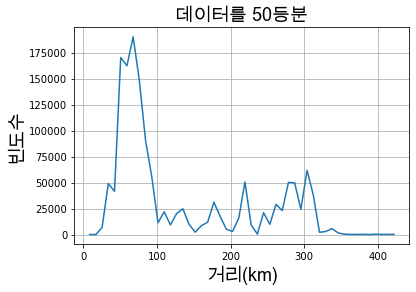

<ipython-input-110-430308ddbf32>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


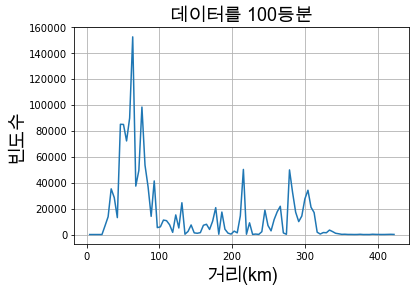

<ipython-input-110-430308ddbf32>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


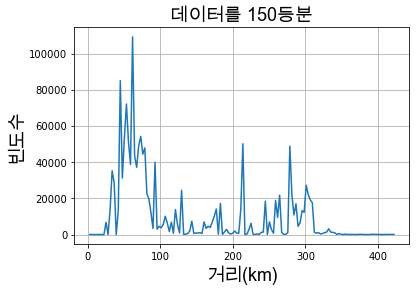

In [110]:
for i in range(51,161,50): 
    plot_x = np.linspace(0,np.max(FC_plot),i) # 구간을 100등분
    Y,X = np.histogram(FC_plot,plot_x)
    plt.title("데이터를 {}등분".format(i-1), fontproperties=fontprop)
    plt.xlabel("거리(km)", fontproperties=fontprop)
    plt.ylabel("빈도수", fontproperties=fontprop)
    ax = plt.axes()   
    ax.yaxis.grid()
    ax.xaxis.grid()
    plt.plot(X[1:],Y)
    plt.show()